In [19]:
import glob
import math
import os
import time

from pathlib import Path
from IPython import display

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import tensorflow_docs.vis.embed as embed

from tensorflow.keras import layers

plt.rcParams["figure.figsize"] = (12, 8)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
ROOT_PATH = Path().resolve().parent

DATA_PATH = ROOT_PATH.joinpath("data")
CHECKPOINT_PATH = ROOT_PATH.joinpath("gan_checkpoints")

MNIST_TRAIN = DATA_PATH.joinpath("sign_mnist_train.csv")
MNIST_TEST = DATA_PATH.joinpath("sign_mnist_test.csv")

In [3]:
train_df = pd.read_csv(MNIST_TRAIN)
train_df = train_df.drop(columns=["label"])

x_train = train_df.values.astype(np.float32)

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = (x_train - 127.5) / 127.5


In [5]:
epochs = 30
batch_size = 64
no_generated = 16

assert math.sqrt(no_generated) == int(math.sqrt(no_generated)), "Ciupaga, the number of generated images must be a perfect square!"

noise_dim = 100
seed = tf.random.normal([no_generated, noise_dim])

2022-02-13 01:05:44.199486: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-13 01:05:44.199512: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fedora-desktop
2022-02-13 01:05:44.199517: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fedora-desktop
2022-02-13 01:05:44.199566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-13 01:05:44.199582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-02-13 01:05:44.199587: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-02-13 01:05:44.199907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU inst

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=len(x_train)).batch(batch_size)

In [7]:
generator = tf.keras.Sequential()

generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

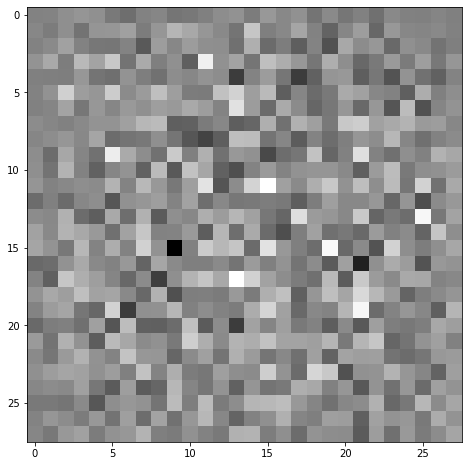

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
discriminator = tf.keras.Sequential()

discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00290527]], shape=(1, 1), dtype=float32)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

manager = tf.train.CheckpointManager(checkpoint, str(CHECKPOINT_PATH), max_to_keep=5)


In [15]:
@tf.function
def train_step(images, batch_size, print_loss):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        if print_loss:
            print(f"Generator loss: {gen_loss}")
            print(f"Discriminator loss: {disc_loss}")

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )



In [16]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    size = int(math.sqrt(no_generated))
    _ = plt.figure(figsize=(size, size))

    for i in range(predictions.shape[0]):
        plt.subplot(size, size, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()


In [17]:
def train(dataset, epochs, batch_size):
    checkpoint.restore(manager.latest_checkpoint)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch}")
        start = time.time()

        batch_num = 0
        for image_batch in dataset:
            print_loss = False
            if batch_num % 4 == 0:
                print_loss = True

            train_step(image_batch, batch_size, print_loss)
            batch_num += 1

        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=str(CHECKPOINT_PATH / "ckpt"))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)


Epoch 0
Generator loss: Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Discriminator loss: Tensor("add:0", shape=(), dtype=float32)
Generator loss: Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Discriminator loss: Tensor("add:0", shape=(), dtype=float32)
Generator loss: Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Discriminator loss: Tensor("add:0", shape=(), dtype=float32)


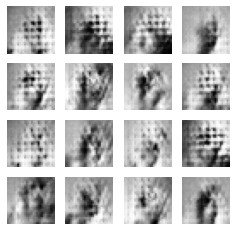

Time for epoch 1 is 55.93565797805786 sec

Epoch 1


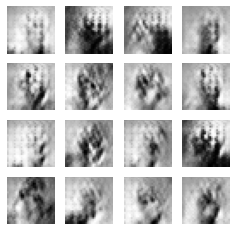

Time for epoch 2 is 49.48614144325256 sec

Epoch 2


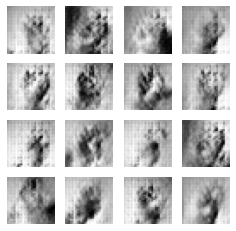

Time for epoch 3 is 53.15601587295532 sec

Epoch 3


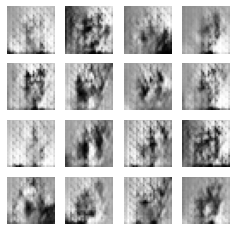

Time for epoch 4 is 47.51841902732849 sec

Epoch 4


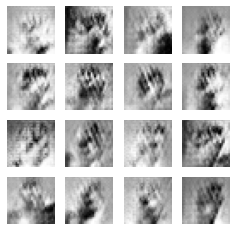

Time for epoch 5 is 46.232203006744385 sec

Epoch 5


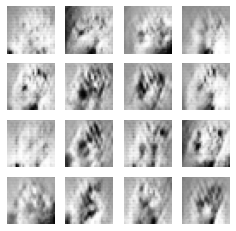

Time for epoch 6 is 45.76171541213989 sec

Epoch 6


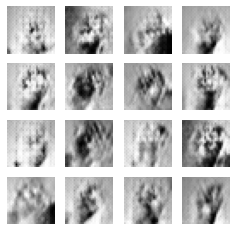

Time for epoch 7 is 51.08721995353699 sec

Epoch 7


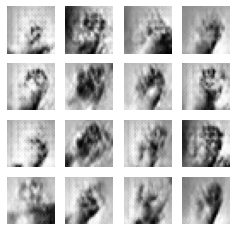

Time for epoch 8 is 51.91567945480347 sec

Epoch 8


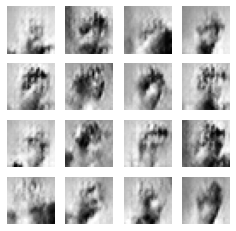

Time for epoch 9 is 47.26870656013489 sec

Epoch 9


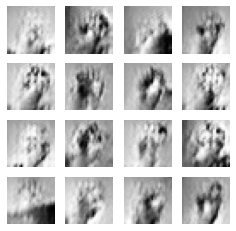

Time for epoch 10 is 45.37392592430115 sec

Epoch 10


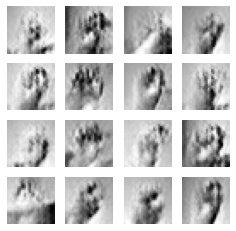

Time for epoch 11 is 50.32801651954651 sec

Epoch 11


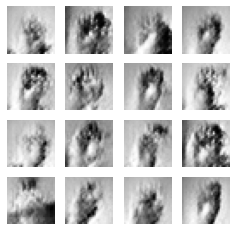

Time for epoch 12 is 51.43302845954895 sec

Epoch 12


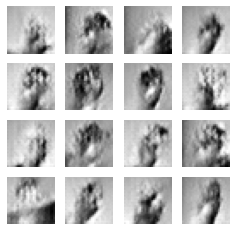

Time for epoch 13 is 50.938416957855225 sec

Epoch 13


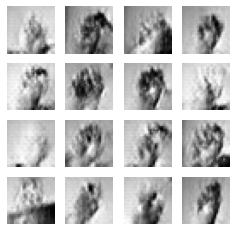

Time for epoch 14 is 46.25975275039673 sec

Epoch 14


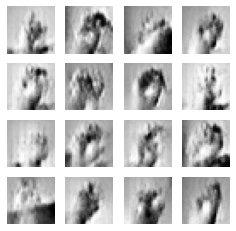

Time for epoch 15 is 53.10544180870056 sec

Epoch 15


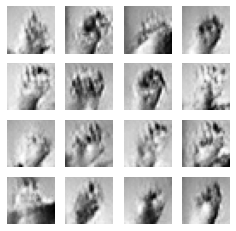

Time for epoch 16 is 54.92875957489014 sec

Epoch 16


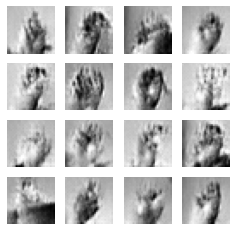

Time for epoch 17 is 53.05829477310181 sec

Epoch 17


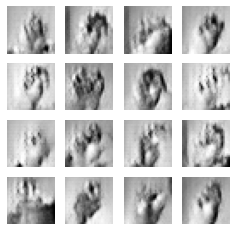

Time for epoch 18 is 48.1970157623291 sec

Epoch 18


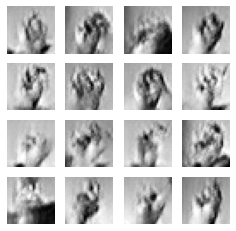

Time for epoch 19 is 49.56795310974121 sec

Epoch 19


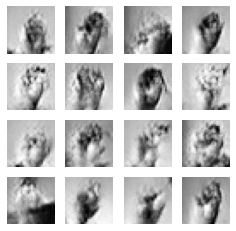

Time for epoch 20 is 50.33126139640808 sec

Epoch 20


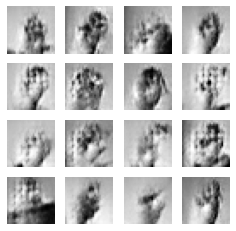

Time for epoch 21 is 54.22600173950195 sec

Epoch 21


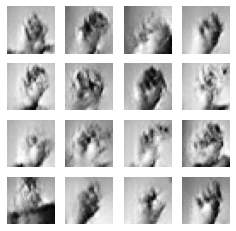

Time for epoch 22 is 50.98100137710571 sec

Epoch 22


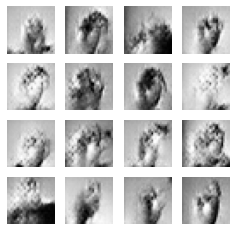

Time for epoch 23 is 50.07020688056946 sec

Epoch 23


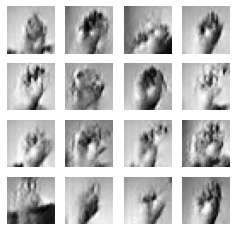

Time for epoch 24 is 49.36532640457153 sec

Epoch 24


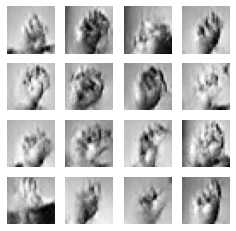

Time for epoch 25 is 50.343003273010254 sec

Epoch 25


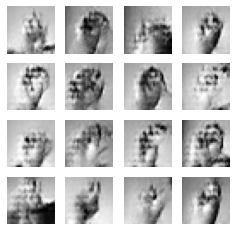

Time for epoch 26 is 52.8210973739624 sec

Epoch 26


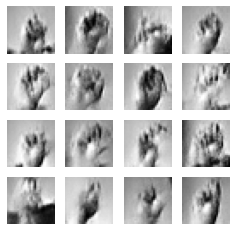

Time for epoch 27 is 53.14435863494873 sec

Epoch 27


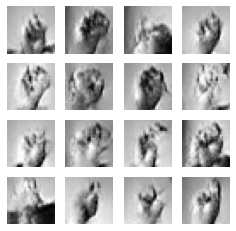

Time for epoch 28 is 49.74217963218689 sec

Epoch 28


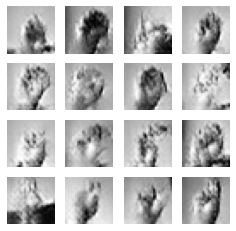

Time for epoch 29 is 50.67343473434448 sec

Epoch 29


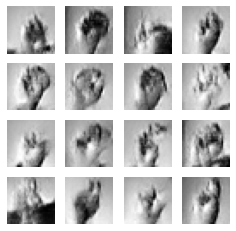

Time for epoch 30 is 51.636993408203125 sec


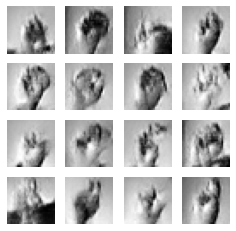

In [18]:
train(dataset, epochs, batch_size)

In [20]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


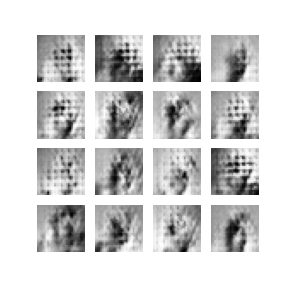

In [22]:
embed.embed_file(anim_file)